<center><image src="https://drive.google.com/uc?id=1n3G4TdK_u6PQHcLrxB_A0HijNdigXmUH">

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Домашнее задание можно разделить на следующие части:

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]
* Мир других лоссов! [2]
  * Dice Loss [1]
  * Focal Loss [1]
  * BONUS: лосс из статьи [5]
* Новая модель! [2]
  * UNet [2]


**Максимальный балл:** 10 баллов.

Также для студентов желающих еще более углубиться в задачу предлагается решить бонусное задание, которое даст дополнительные 5 баллов. BONUS задание необязательное.


# Загрузка данных

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>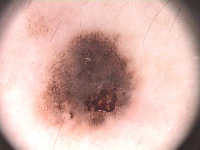</td><td>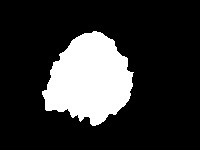</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!gdown 1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql

Downloading...
From (original): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql
From (redirected): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql&confirm=t&uuid=f38c8ff6-6928-4b29-9863-6f316f9e6a02
To: /content/PH2Dataset.rar
100% 162M/162M [00:03<00:00, 47.6MB/s]


In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

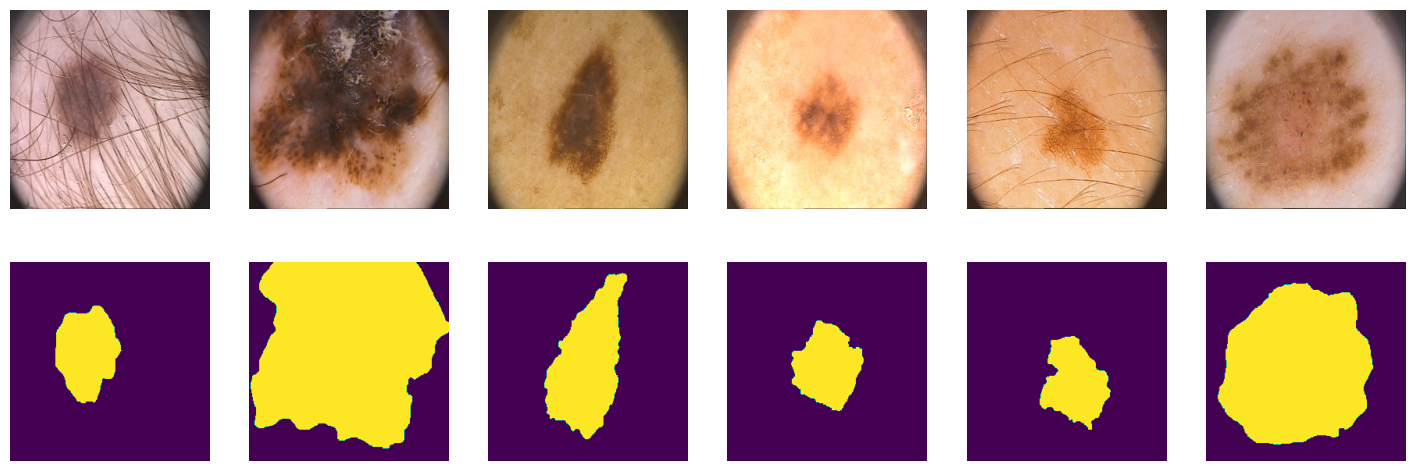

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 16
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Метрика

## IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Что будет являться пересением и объединением в задаче сегментации?

Давайте разберем следующий пример:





<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1rBYFgli48AUUN9idiyq8j3J5DboB93yN" width=1000 height=800/></p>

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 50.3 MB/s eta 0:00:00


In [ ]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

# Построй свой первый бейзлайн!

Итак, загрузка файлов, код датасета и даталоадера написана за вас. Метрика IoU написана за вас! Вам остается написать лосс, модель и функции обучения и теста модели.

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]

## BCE Loss [2 балла]

Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

### Вывод численно стабильной формулы BCE лосса [1 балл]



Выведите из формулы [1] формулу [2]:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

Не забываем, что здесь $\hat y_i$ - это логиты сети, не вероятности и не лейблы.

**Ответ:** $$\mathcal L_{BCE}(y, \hat y) = -\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space = \left[-y\log(1/(1+exp(-\hat y)) - (1-y)(log(exp(-\hat y))/(1+exp(-\hat y)))\right] \space = \left[y\log(1+exp(-\hat y)) + (1-y)(-log(exp(-\hat y))+log(1+exp(-\hat y)))\right] \space  =  \left[y\log(1+exp(-\hat y)) + (1-y)((\hat y)+log(1+exp(-\hat y)))\right] \space =  \left[(1-y)(\hat y)+log(1+exp(-\hat y))\right] \space =  \left[\hat y - y(\hat y)+log(1+exp(-\hat y))\right] \space$$

### Реализуйте в коде оба варианта лосса [1 балл]

Реализуйте следующие функции:

*   `bce_true()` - честная прямая реализация лосса с формулой $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
*   `bce_loss()` - реализация формулы, которую мы вывели $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

И сравните результаты функций с реализацией Pytorch:
*   `bce_torch()`
*   `bce_torch_with_logits()`

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

In [ ]:
bce_torch = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [ ]:
from math import exp
def bce_loss(y_pred, y_real):
  loss = -y_real*torch.log(torch.sigmoid(y_pred)) - (1 - y_real)*torch.log(1-torch.sigmoid(y_pred))
  return loss.sum()
def bce_true(y_pred, y_real):
  loss = y_pred - y_real*y_pred + torch.log(1+torch.exp(-y_pred))
  return loss.sum()

Проверим корректность работы на простом примере

In [ ]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true)}')


BCE loss from scratch bce_loss = 6.6042866706848145
BCE loss честно посчитанный = 6.6042866706848145
BCE loss from torch bce_torch = 6.6042866706848145
BCE loss from torch with logits bce_torch = 6.6042866706848145


Инструкции `assert` в Python — это булевы выражения, которые проверяют, является ли условие истинным (`True`). Внизу в коде мы проверяем функция `bce_loss()` выдает тот же результат, что и функция из Pytorch или нет. Если равенства не будет, что будет означать, что результаты функций не совпадают, а значит вы неправильно реализовали фукнцию `bce_loss()`, `assert` возвратит ошибку.

Функция `numpy.isclose()` используется для сравнения двух чисел с учётом допустимой погрешности. Она особенно полезна при работе с числами с плавающей точкой, где точное сравнение может быть проблематичным из-за ограничений представления таких чисел в компьютере.

Как она работает?

`numpy.isclose(a, b, rtol=1e-05, atol=1e-08) `принимает два числа (`a` и `b`) и сравнивает их, учитывая относительную и абсолютную погрешность. Если разница между двумя числами меньше заданного порога, функция возвращает `True`, иначе — `False`.

Параметры:

    rtol: Относительная погрешность (по умолчанию 1e-05). Используется для определения разницы относительно большего значения.
    atol: Абсолютная погрешность (по умолчанию 1e-08). Определяет минимальную разницу, которую следует учитывать.

Мы будем использовать `assert` и `numpy.isclose()` для проверки корректности нашего кода.

In [ ]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

Давайте теперь посчитаем на простом примере, но с теми же размерностями, что и в датасете

In [ ]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss from scratch bce_loss = 14.065452575683594
BCE loss честно посчитанный = 14.065454483032227
BCE loss from torch bce_torch = 14.065452575683594
BCE loss from torch with logits bce_torch = 14.06545352935791


In [ ]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

Давайте посчитаем на реальных логитах и сегментационной маске:

In [ ]:
!gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M

Retrieving folder contents
Processing file 1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC labels.pt
Processing file 1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I logits.pt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC
To: /content/for_asserts/labels.pt
100% 1.18k/1.18k [00:00<00:00, 7.02MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I
To: /content/for_asserts/logits.pt
100% 1.18k/1.18k [00:00<00:00, 6.08MB/s]
Download completed


In [ ]:
path_to_dummy_samples = '/content/for_asserts'
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

<ipython-input-23-cd9dbfff2c1b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
<ipython-input-

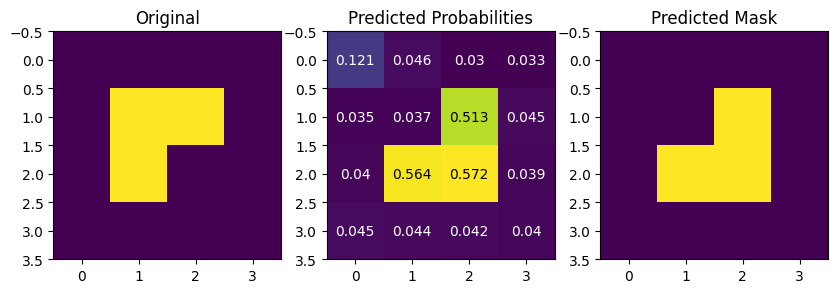

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [ ]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())
assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

## SegNet [2 балла]

Ваше задание здесь состоит в том, чтобы реализовать SegNet архитектуру.

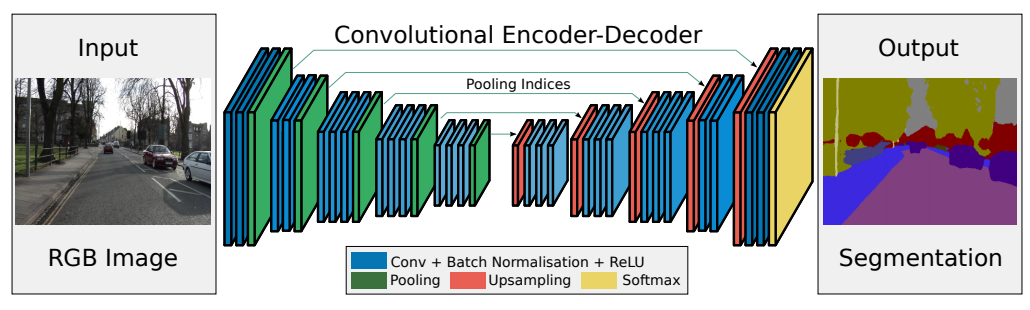

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

Хорошие ресурсы по SegNet архитектуре:
1. https://medium.com/@nikdenof/segnet-from-scratch-using-pytorch-3fe9b4527239


In [ ]:
class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        #VGG 16
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2,return_indices=True)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2,return_indices=True)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3_1 = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(256)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn3_3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2,return_indices=True)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4_1 = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn4_2 = nn.BatchNorm2d(512)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn4_3 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2,return_indices=True)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5_1 = nn.BatchNorm2d(512)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5_2 = nn.BatchNorm2d(512)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5_3 = nn.BatchNorm2d(512)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2,return_indices=True)


        # bottleneck

        self.bottle = nn.Conv2d(512, 512, kernel_size = 1)

        # decoder (upsampling)
        self.upsampling1_1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.de_bn1_1 = nn.BatchNorm2d(512)
        self.de_conv1_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.de_bn1_2 = nn.BatchNorm2d(512)
        self.de_conv1_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.de_bn1_3 = nn.BatchNorm2d(512)
        self.de_conv1_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upsampling2_1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.de_bn2_1 = nn.BatchNorm2d(512)
        self.de_conv2_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.de_bn2_2 = nn.BatchNorm2d(512)
        self.de_conv2_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.de_bn2_3 = nn.BatchNorm2d(512)
        self.de_conv2_3 = nn.Conv2d(512, 256, kernel_size=3, padding=1)

        self.upsampling3_1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.de_bn3_1 = nn.BatchNorm2d(256)
        self.de_conv3_1 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.de_bn3_2 = nn.BatchNorm2d(256)
        self.de_conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.de_bn3_3 = nn.BatchNorm2d(256)
        self.de_conv3_3 = nn.Conv2d(256, 128, kernel_size=3, padding=1)

        self.upsampling4_1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.de_bn4_1 = nn.BatchNorm2d(128)
        self.de_conv4_1 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.de_bn4_2 = nn.BatchNorm2d(128)
        self.de_conv4_2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)

        self.upsampling5_1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.de_bn5_1 = nn.BatchNorm2d(64)
        self.de_conv5_1 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.de_bn5_2 = nn.BatchNorm2d(64)
        self.de_conv5_2 = nn.Conv2d(64, 1, kernel_size=3, padding=1)




    def forward(self, x):
        # encoder
        x1 = F.relu(self.bn1_1(self.conv1_1(x)))
        x1 = F.relu(self.bn1_2(self.conv1_2(x1)))
        x1, ind1 = self.pool1(x1)

        x2 = F.relu(self.bn2_1(self.conv2_1(x1)))
        x2 = F.relu(self.bn2_2(self.conv2_2(x2)))
        x2, ind2 = self.pool2(x2)

        x3 = F.relu(self.bn3_1(self.conv3_1(x2)))
        x3 = F.relu(self.bn3_2(self.conv3_2(x3)))
        x3 = F.relu(self.bn3_3(self.conv3_3(x3)))
        x3, ind3 = self.pool3(x3)

        x4 = F.relu(self.bn4_1(self.conv4_1(x3)))
        x4 = F.relu(self.bn4_2(self.conv4_2(x4)))
        x4 = F.relu(self.bn4_3(self.conv4_3(x4)))
        x4, ind4 = self.pool4(x4)

        x5 = F.relu(self.bn5_1(self.conv5_1(x4)))
        x5 = F.relu(self.bn5_2(self.conv5_2(x5)))
        x5 = F.relu(self.bn5_3(self.conv5_3(x5)))
        x5, ind5 = self.pool5(x5)


        # bottleneck
        b = self.bottle(x5)

        # decoder
        y1 = self.upsampling1_1(b, ind5)
        y1 = (self.de_conv1_1(self.de_bn1_1(F.relu(y1))))
        y1 = (self.de_conv1_2(self.de_bn1_2(F.relu(y1))))
        y1 = (self.de_conv1_3(self.de_bn1_3(F.relu(y1))))


        y2 = self.upsampling2_1(y1,ind4)
        y2 = (self.de_conv2_1(self.de_bn2_1(F.relu(y2))))
        y2 = (self.de_conv2_2(self.de_bn2_2(F.relu(y2))))
        y2 = (self.de_conv2_3(self.de_bn2_3(F.relu(y2))))

        y3 = self.upsampling3_1(y2,ind3)
        y3 = (self.de_conv3_1(self.de_bn3_1(F.relu(y3))))
        y3 = (self.de_conv3_2(self.de_bn3_2(F.relu(y3))))
        y3 = (self.de_conv3_3(self.de_bn3_3(F.relu(y3))))


        y4= self.upsampling4_1(y3,ind2)
        y4 = (self.de_conv4_1(self.de_bn4_1(F.relu(y4))))
        y4 = (self.de_conv4_2(self.de_bn4_2(F.relu(y4))))


        y5 = self.upsampling5_1(y4,ind1)
        y5 =(self.de_conv5_1(self.de_bn5_1(F.relu(y5))))
        output = (self.de_conv5_2(self.de_bn5_2(F.relu(y5))))



        return output # no activation

In [ ]:
segnet_model = SegNet().to(device)

## Тренировка [1 балл]

Напишите функцию для обучения модели.

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
import torch
from torchmetrics import JaccardIndex

from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

In [ ]:
def train_single_epoch(model, optimizer, criterion, train_dataloader, device):
    model.train()

    avg_loss = 0
    for X_batch, Y_batch in tqdm(train_dataloader):
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        Y_pred = model(X_batch)

        loss = criterion(Y_pred, Y_batch) # forward-pass

        loss.backward()  # backward-pass
        optimizer.step()  # update weights
        optimizer.zero_grad() # set parameter gradients to zero

        # calculate loss to show the user
        avg_loss += loss

    avg_loss = avg_loss/len(train_dataloader)

    return model, avg_loss

def validate_single_epoch(model, criterion, valid_dataloader, device):

    iou_score = JaccardIndex(threshold=0.5, task="binary",average='none').to(device)
    model.eval()

    avg_loss = 0
    avg_iou = 0
    with torch.no_grad():
      for X_batch, Y_batch in tqdm(valid_dataloader):
          X_batch = X_batch.to(device)
          Y_batch = Y_batch.to(device)

          Y_pred = model(X_batch)
          iou = iou_score(Y_pred, Y_batch)
          loss = criterion(Y_pred, Y_batch)
          avg_loss += loss
          avg_iou += iou

    avg_loss = avg_loss/len(valid_dataloader)
    avg_iou = avg_iou/len(valid_dataloader)


    return model, avg_loss, avg_iou

def train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path):

    total_train_loss = []
    total_val_loss = []
    total_val_iou = []

    best_val_loss = float('inf')
    best_val_iou = 0

    for epoch in tqdm(range(epochs)):

        model, train_loss = train_single_epoch(model, optimizer, criterion, train_dataloader, device)

        model, val_loss, val_iou = validate_single_epoch(model, criterion, valid_dataloader, device)

        print(f'Epoch {epoch}: train loss = {train_loss}')
        print(f'Epoch {epoch}: val loss = {val_loss}')
        print(f'Epoch {epoch}: val iou = {val_iou}')

        total_train_loss.append(train_loss.cpu().detach().numpy())
        total_val_loss.append(val_loss.cpu().detach().numpy())
        total_val_iou.append(val_iou.cpu().detach().numpy())

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'{ckpt_path}/epoch_{epoch}_best_val_loss.pt')

        torch.save(model.state_dict(), f'{ckpt_path}/epoch_{epoch}_val_iou.pt')


    statistics = {'train loss': total_train_loss,
                  'val_loss': total_val_loss,
                  'val_iou': total_val_iou}

    return model, statistics

Обучите модель **SegNet**. В качестве оптимайзера можно взять Adam.

In [ ]:
optimizer = torch.optim.Adam(segnet_model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
epochs = 25
ckpt_path = "/content/drive/My Drive/checkpoints"
torch.cuda.empty_cache()
model, statistics = train(segnet_model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 0: train loss = 0.6687827706336975
Epoch 0: val loss = 0.661106526851654
Epoch 0: val iou = 9.190309356199577e-05


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: train loss = 0.4860769808292389
Epoch 1: val loss = 0.9980635643005371
Epoch 1: val iou = 0.21586820483207703


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2: train loss = 0.3358052372932434
Epoch 2: val loss = 1.576305627822876
Epoch 2: val iou = 0.3953584134578705


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3: train loss = 0.30699622631073
Epoch 3: val loss = 1.1835291385650635
Epoch 3: val iou = 0.5590201616287231


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4: train loss = 0.2811211347579956
Epoch 4: val loss = 0.5325812101364136
Epoch 4: val iou = 0.5983466506004333


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5: train loss = 0.23350051045417786
Epoch 5: val loss = 0.23342761397361755
Epoch 5: val iou = 0.7030414342880249


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6: train loss = 0.25422051548957825
Epoch 6: val loss = 0.22142231464385986
Epoch 6: val iou = 0.6962615847587585


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7: train loss = 0.23593443632125854
Epoch 7: val loss = 0.18979650735855103
Epoch 7: val iou = 0.7829986214637756


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8: train loss = 0.23531877994537354
Epoch 8: val loss = 0.25664782524108887
Epoch 8: val iou = 0.7187991142272949


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9: train loss = 0.22431986033916473
Epoch 9: val loss = 0.3000279664993286
Epoch 9: val iou = 0.7292435169219971


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10: train loss = 0.1998479962348938
Epoch 10: val loss = 0.1958620250225067
Epoch 10: val iou = 0.7695502638816833


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11: train loss = 0.20276600122451782
Epoch 11: val loss = 0.2534482181072235
Epoch 11: val iou = 0.7214522361755371


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12: train loss = 0.24883928894996643
Epoch 12: val loss = 0.22677358984947205
Epoch 12: val iou = 0.7709985375404358


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13: train loss = 0.21918579936027527
Epoch 13: val loss = 0.27820828557014465
Epoch 13: val iou = 0.6953083276748657


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14: train loss = 0.21945329010486603
Epoch 14: val loss = 0.3004862368106842
Epoch 14: val iou = 0.6678861379623413


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15: train loss = 0.17719657719135284
Epoch 15: val loss = 0.25414353609085083
Epoch 15: val iou = 0.7152377367019653


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16: train loss = 0.17847026884555817
Epoch 16: val loss = 0.17789624631404877
Epoch 16: val iou = 0.7843361496925354


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17: train loss = 0.21434026956558228
Epoch 17: val loss = 0.19526535272598267
Epoch 17: val iou = 0.7418652176856995


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18: train loss = 0.22372162342071533
Epoch 18: val loss = 0.17113709449768066
Epoch 18: val iou = 0.7470705509185791


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19: train loss = 0.22254915535449982
Epoch 19: val loss = 0.3104656934738159
Epoch 19: val iou = 0.655745804309845


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20: train loss = 0.20192839205265045
Epoch 20: val loss = 0.285077840089798
Epoch 20: val iou = 0.7373465895652771


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21: train loss = 0.21784521639347076
Epoch 21: val loss = 0.23059052228927612
Epoch 21: val iou = 0.7581673860549927


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22: train loss = 0.2135675698518753
Epoch 22: val loss = 0.18885308504104614
Epoch 22: val iou = 0.8067685961723328


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23: train loss = 0.18289628624916077
Epoch 23: val loss = 0.15601135790348053
Epoch 23: val iou = 0.8188448548316956


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24: train loss = 0.16798442602157593
Epoch 24: val loss = 0.18133527040481567
Epoch 24: val iou = 0.7570174932479858


## Инференс [1 балл]

После обучения модели напишите фукнцию теста, воспользуйтесь лучшим чекпоинтом и протестируйте работу модели на тестовой выборке.

In [ ]:
# Test для предсказания
import matplotlib.pyplot as plt

def test(model, test_dataloader, device, ckpt_path, ckpt_name, plot=True):
    model.load_state_dict(torch.load(f'{ckpt_path}/{ckpt_name}'))
    model.to(device)
    model.eval()

    iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)
    avg_iou = 0

    with torch.no_grad():
        for X_batch, Y_batch in test_dataloader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            Y_pred = model(X_batch)
            Y_pred = torch.sigmoid(Y_pred)
            Y_pred = (Y_pred > 0.5).float()

            batch_iou = iou_score(Y_pred, Y_batch)
            avg_iou += batch_iou.sum()


            if plot:
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))

                axes[0].imshow(X_batch[0].permute(1, 2, 0).cpu().detach().numpy())
                axes[1].imshow(Y_batch[0].squeeze(0).cpu().detach().numpy())
                axes[2].imshow(Y_pred[0].squeeze(0).cpu().detach().numpy())

                plt.tight_layout()
                plt.show()


        avg_iou = avg_iou / len(test_dataloader)

    return avg_iou.item()

<ipython-input-60-9fc145c13f55>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{ckpt_path}/{ckpt_name}'))


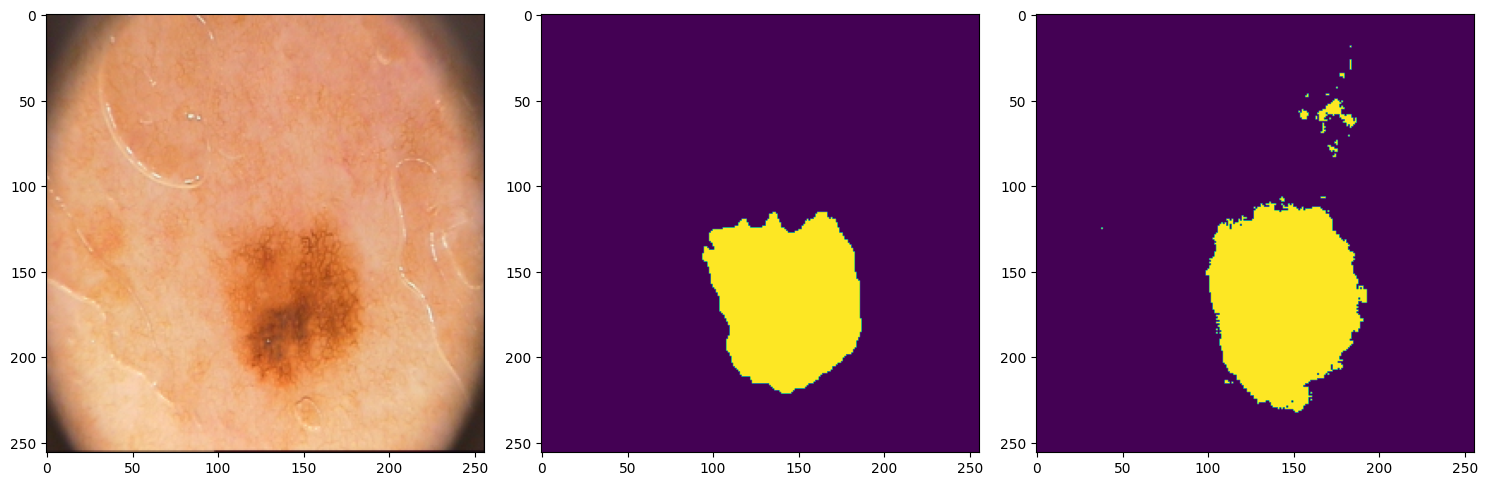

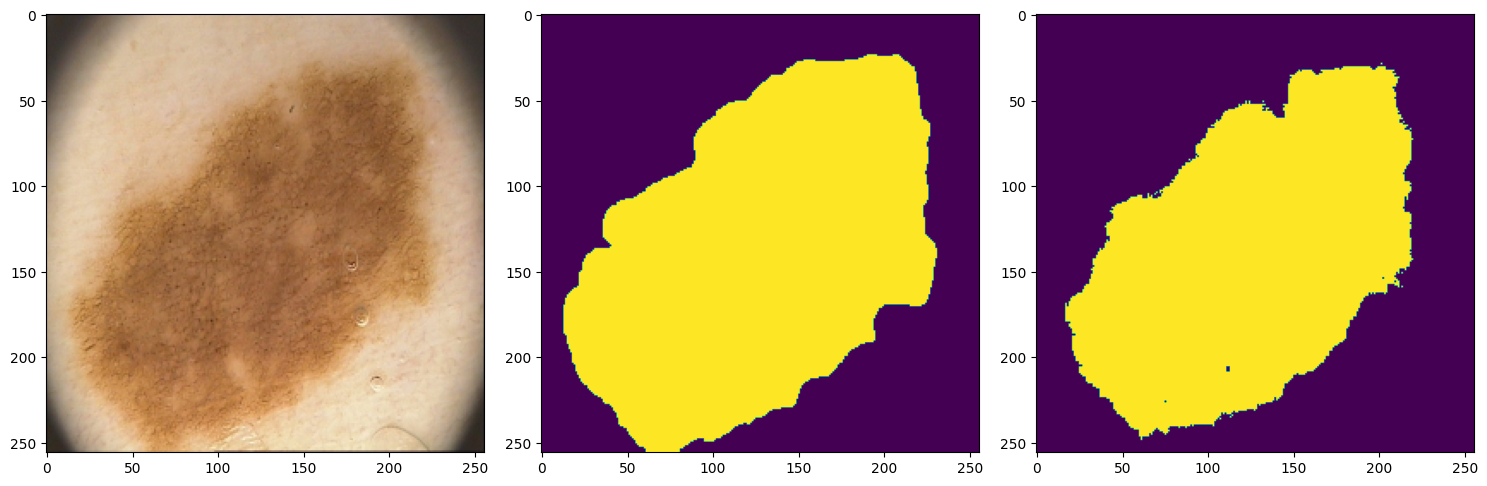

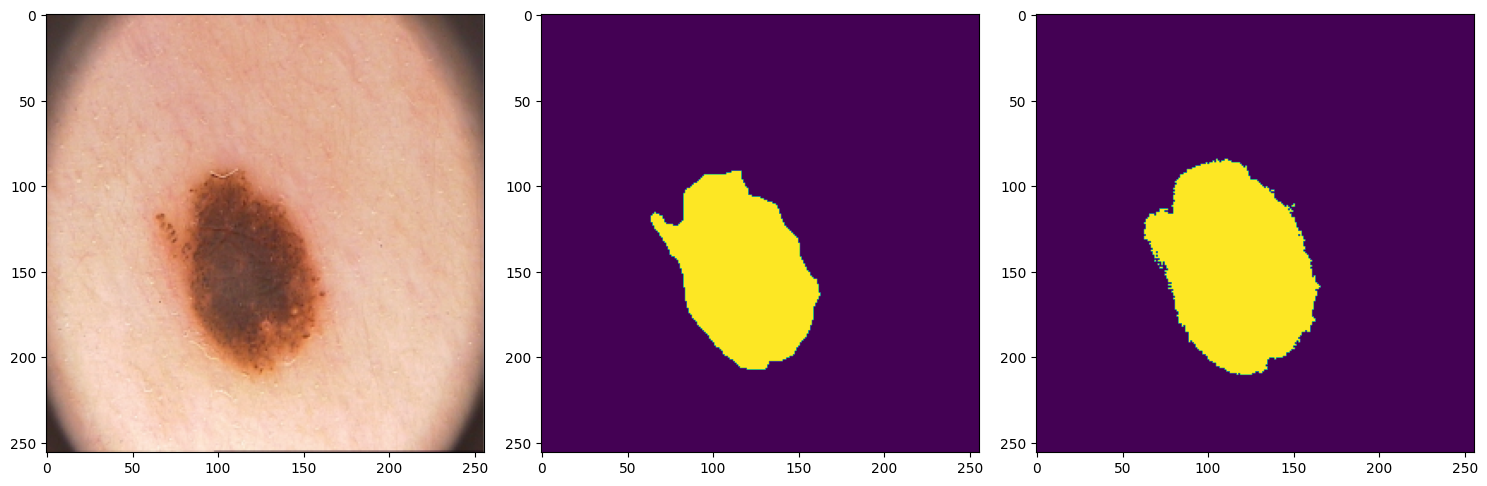

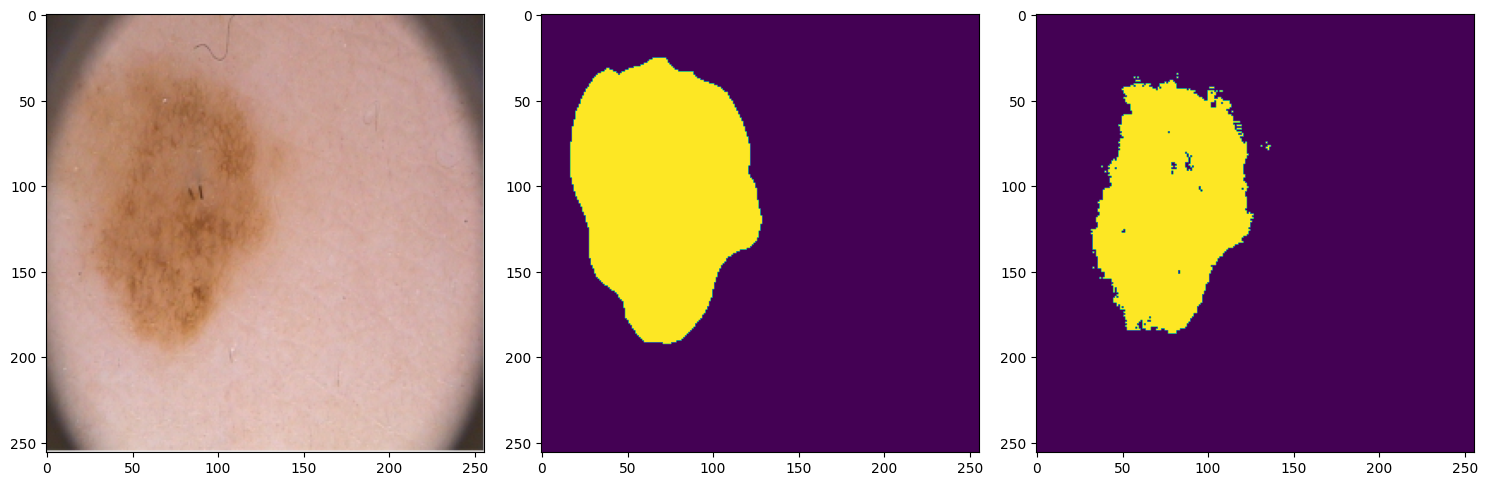

0.7400957942008972

In [ ]:
# Делаем предсказание и визуализацию
test(model, test_dataloader, device, ckpt_path, ckpt_name = 'epoch_23_val_iou.pt', plot = True)

# Мир других лоссов!

## Дополнительные функции потерь [2 балла]

В данном разделе вам потребуется имплементировать две функции потерь: DICE и Focal loss.


### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

**Hints** (!):

1. Не забудьте подумать о численной нестабильности, возникающей в математической формуле при ситуации, когда $\frac{0}{0}$, т.е. вам нужно добавить очень маленькое число, например $\epsilon = 1e^{-8}$, в обе части дроби при подсчете $D(X,Y)$:

$$D(X,Y) = \frac{2TP + ϵ}{2TP + FP + FN + ϵ}$$

2. Dice метрика(!), не лосс, считается похожим образом как IoU:

    2.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    2.2. Фиксируем порог, например threshold=0.5, и всему что ниже порога ставим значение 0, всему что выше 1. Получаем предсказанную маску из 0 и 1.

    2.3. Считаем TP, FP, FN

    2.4. Считаем DICE метрику по формуле

Вы можете прописать для себя функцию `dice_score()` и сравнить с результатами работы функции из библиотеки `torchmetrics`.

3. Но с метрикой есть проблема, что она не дифференцируема, и если вы захотите просто взять и прописать `dice_loss` = 1 - `dice_score`, Pytorch поругается на вас и скажет, что это недифференцируемая метрика. Чтобы посчитать dice_loss делаем следующие шаги:

    3.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    3.2. Здесь нам уже не нужно фиксировать порог, мы просто работаем с вероятностями. Значения вероятностей дифференцируемы и через них будут протекать градиенты.

    3.3. Считаем TP, FP, FN также как и в Dice метрике, только вместо маски, подаем вероятности.

    3.4. Считаем DICE метрику по формуле

    3.5. Считаем лосс как Loss = 1 - DICE

Итак, давайте сначала пропишем dice_score.

In [ ]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5):
    '''
    Это именно метрика, не лосс.
    '''
    output = torch.sigmoid(logits)
    predict = (output > threshold).int()


    TP = torch.sum((predict == 1) & (labels == 1))
    FP = torch.sum((predict == 1) & (labels == 0))
    FN = torch.sum((predict == 0) & (labels == 1))

    score = (2 * TP + 1e-17) / (2 * TP + FP + FN + 1e-17)

    return score

Проверим на корректность функцию dice_score:

In [ ]:
from torchmetrics.classification import Dice

dice = Dice(average='micro').to(device)
dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int))

tensor(0.6667, device='cuda:0')

In [ ]:
assert dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int)) == dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

Давайте теперь пропишем лосс и воспользуемся библиотекой `segmentation-models-pytorch`, чтобы убедиться в корректности нашей функции.

In [ ]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor):

      output = torch.sigmoid(logits)

      TP = torch.sum(output * labels)
      FP = torch.sum(output * (1 - labels))
      FN = torch.sum((1 - output) * labels)

      dice = (2 * TP + 1e-17) / (2 * TP + FP + FN + 1e-17)

      loss = 1 - dice


      return loss

Проверка на корректность:

In [ ]:
pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=b5ab21525c2559e186892070cd7d9666085f2130996bc7214e1e4d04f6a33d9d
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=aaf4efb923d52225623e8b4f41b8b26d5a05d0e8e59e2d015e069fe6ebe2f4ba
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

In [ ]:
from segmentation_models_pytorch.losses import DiceLoss
dice_loss_torch = DiceLoss(mode='binary')
dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756, device='cuda:0')

In [ ]:
assert dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'].to(int)) == dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

### Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.


Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [ ]:
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='none')
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):

    y_pred_sigmoid = torch.sigmoid(y_pred)

    p_t = y_real * y_pred_sigmoid + (1 - y_real) * (1 - y_pred_sigmoid)

    loss = (1 - p_t) ** gamma * (bce_torch_with_logits(y_pred, y_real))

    return loss.sum()

Проверка корректности функции:

In [ ]:
from torchvision.ops import sigmoid_focal_loss
sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum')

tensor(3.6161, device='cuda:0')

In [ ]:
focal_loss(dummpy_sample['labels'], dummpy_sample['logits'], gamma=2.0)

tensor(3.6161, device='cuda:0')

In [ ]:
assert sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum') == focal_loss(dummpy_sample['labels'], dummpy_sample['logits'], gamma=2.0)

## Обучите SegNet на новых лоссах

**Задание**: обучите SegNet на новых лоссах и сравните все три лосса:
*   При каком лоссе модель сходится быстрее?
*   При каком лоссе модель выдает наилучшую метрику?

Напишите развернутый ответ на вопросы.



In [ ]:
# Train для Dice
def train_single_epoch(model, optimizer, train_dataloader, device):
    model.train()

    avg_loss = 0
    for X_batch, Y_batch in tqdm(train_dataloader):
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        Y_pred = model(X_batch)

        loss = dice_loss(Y_pred, Y_batch)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        avg_loss += loss

    avg_loss = avg_loss/len(train_dataloader)

    return model, avg_loss

def validate_single_epoch(model, valid_dataloader, device):

    iou_score = JaccardIndex(threshold=0.5, task="binary",average='none').to(device)
    model.eval()

    avg_loss = 0
    avg_iou = 0
    with torch.no_grad():
      for X_batch, Y_batch in tqdm(valid_dataloader):
          X_batch = X_batch.to(device)
          Y_batch = Y_batch.to(device)

          Y_pred = model(X_batch)
          iou = iou_score(Y_pred, Y_batch)
          loss = dice_loss(Y_pred, Y_batch)
          avg_loss += loss
          avg_iou += iou

    avg_loss = avg_loss/len(valid_dataloader)
    avg_iou = avg_iou/len(valid_dataloader)


    return model, avg_loss, avg_iou

def train(model, optimizer, epochs, train_dataloader, valid_dataloader, device):

    total_train_loss = []
    total_val_loss = []
    total_val_iou = []

    best_val_loss = float('inf')
    best_val_iou = 0

    for epoch in tqdm(range(epochs)):

        model, train_loss = train_single_epoch(model, optimizer, train_dataloader, device)

        model, val_loss, val_iou = validate_single_epoch(model, valid_dataloader, device)

        print(f'Epoch {epoch}: train loss = {train_loss}')
        print(f'Epoch {epoch}: val loss = {val_loss}')
        print(f'Epoch {epoch}: val iou = {val_iou}')

        total_train_loss.append(train_loss.cpu().detach().numpy())
        total_val_loss.append(val_loss.cpu().detach().numpy())
        total_val_iou.append(val_iou.cpu().detach().numpy())




    statistics = {'train loss': total_train_loss,
                  'val_loss': total_val_loss,
                  'val_iou': total_val_iou}

    return model, statistics

In [ ]:
optimizer = torch.optim.Adam(segnet_model.parameters(), lr=1e-3)
epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
model1, statistics1 = train(segnet_model, optimizer, epochs, train_dataloader, valid_dataloader, device)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 0: train loss = 0.25605103373527527
Epoch 0: val loss = 0.5083296298980713
Epoch 0: val iou = 0.33190983533859253


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: train loss = 0.1893153041601181
Epoch 1: val loss = 0.5297456979751587
Epoch 1: val iou = 0.3104744553565979


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2: train loss = 0.18023858964443207
Epoch 2: val loss = 0.32246869802474976
Epoch 2: val iou = 0.5253234505653381


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3: train loss = 0.14990733563899994
Epoch 3: val loss = 0.3671249747276306
Epoch 3: val iou = 0.47505486011505127


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4: train loss = 0.16008621454238892
Epoch 4: val loss = 0.18383023142814636
Epoch 4: val iou = 0.7032803297042847


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5: train loss = 0.12836802005767822
Epoch 5: val loss = 0.13153252005577087
Epoch 5: val iou = 0.7803900241851807


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6: train loss = 0.1296670287847519
Epoch 6: val loss = 0.2005244642496109
Epoch 6: val iou = 0.6764804720878601


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7: train loss = 0.13507191836833954
Epoch 7: val loss = 0.13977470993995667
Epoch 7: val iou = 0.7617877125740051


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8: train loss = 0.12060978263616562
Epoch 8: val loss = 0.12690579891204834
Epoch 8: val iou = 0.7771554589271545


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9: train loss = 0.1212020292878151
Epoch 9: val loss = 0.13480021059513092
Epoch 9: val iou = 0.7676399350166321


In [ ]:
# Train для focal loss
def train_single_epoch(model, optimizer, train_dataloader, device):
    model.train()

    avg_loss = 0
    for X_batch, Y_batch in tqdm(train_dataloader):
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        Y_pred = model(X_batch)

        loss = focal_loss(Y_batch, Y_pred, gamma=2)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        avg_loss += loss

    avg_loss = avg_loss/len(train_dataloader)

    return model, avg_loss

def validate_single_epoch(model, valid_dataloader, device):

    iou_score = JaccardIndex(threshold=0.5, task="binary",average='none').to(device)
    model.eval()

    avg_loss = 0
    avg_iou = 0
    with torch.no_grad():
      for X_batch, Y_batch in tqdm(valid_dataloader):
          X_batch = X_batch.to(device)
          Y_batch = Y_batch.to(device)

          Y_pred = model(X_batch)
          iou = iou_score(Y_pred, Y_batch)
          loss = focal_loss(Y_batch, Y_pred, gamma=2)
          avg_loss += loss
          avg_iou += iou

    avg_loss = avg_loss/len(valid_dataloader)
    avg_iou = avg_iou/len(valid_dataloader)


    return model, avg_loss, avg_iou

def train(model, optimizer, epochs, train_dataloader, valid_dataloader, device):

    total_train_loss = []
    total_val_loss = []
    total_val_iou = []

    best_val_loss = float('inf')
    best_val_iou = 0

    for epoch in tqdm(range(epochs)):

        model, train_loss = train_single_epoch(model, optimizer, train_dataloader, device)

        model, val_loss, val_iou = validate_single_epoch(model, valid_dataloader, device)

        print(f'Epoch {epoch}: train loss = {train_loss}')
        print(f'Epoch {epoch}: val loss = {val_loss}')
        print(f'Epoch {epoch}: val iou = {val_iou}')

        total_train_loss.append(train_loss.cpu().detach().numpy())
        total_val_loss.append(val_loss.cpu().detach().numpy())
        total_val_iou.append(val_iou.cpu().detach().numpy())




    statistics = {'train loss': total_train_loss,
                  'val_loss': total_val_loss,
                  'val_iou': total_val_iou}

    return model, statistics

In [ ]:
optimizer = torch.optim.Adam(segnet_model.parameters(), lr=1e-3)
epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
model2, statistics2 = train(segnet_model, optimizer, epochs, train_dataloader, valid_dataloader, device)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 0: train loss = 54850.94140625
Epoch 0: val loss = 61113.671875
Epoch 0: val iou = 0.668938159942627


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: train loss = 54359.32421875
Epoch 1: val loss = 61594.73828125
Epoch 1: val iou = 0.7284780144691467


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2: train loss = 48624.77734375
Epoch 2: val loss = 52562.72265625
Epoch 2: val iou = 0.8093852996826172


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3: train loss = 49833.81640625
Epoch 3: val loss = 59371.15625
Epoch 3: val iou = 0.7698395252227783


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4: train loss = 42170.640625
Epoch 4: val loss = 62723.89453125
Epoch 4: val iou = 0.7698686718940735


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5: train loss = 47514.69921875
Epoch 5: val loss = 42611.171875
Epoch 5: val iou = 0.7883085012435913


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6: train loss = 54710.3828125
Epoch 6: val loss = 57331.6953125
Epoch 6: val iou = 0.7002522945404053


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7: train loss = 45117.91015625
Epoch 7: val loss = 62281.69140625
Epoch 7: val iou = 0.6828158497810364


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8: train loss = 47958.9921875
Epoch 8: val loss = 42823.59765625
Epoch 8: val iou = 0.7695712447166443


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9: train loss = 44506.7109375
Epoch 9: val loss = 47827.24609375
Epoch 9: val iou = 0.7969782948493958


# Новая модель!

## U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

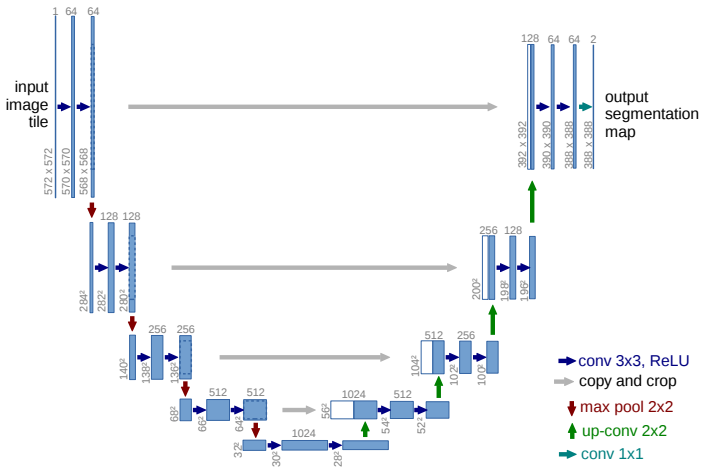

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

In [ ]:
# Архитектура Unet
class UNet(nn.Module):
    def __init__(self, n_class=1):
        super().__init__()

        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # bottleneck
        self.conv5_1 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)


        # decoder (upsampling)
        self.upconv1_1 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)
        self.de_conv1_1 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.de_conv1_2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)


        self.upconv2_1 = nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2)
        self.de_conv2_1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.de_conv2_2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)

        self.upconv3_1 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)
        self.de_conv3_1 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.de_conv3_2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)

        self.upconv4_1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.de_conv4_1 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.de_conv4_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.de_conv4_3 = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, x):
        x1 = F.relu((self.conv1_1(x)))
        x1 = F.relu((self.conv1_2(x1)))
        x1_p= self.pool1(x1)

        x2 = F.relu((self.conv2_1(x1_p)))
        x2 = F.relu((self.conv2_2(x2)))
        x2_p = self.pool2(x2)

        x3 = F.relu((self.conv3_1(x2_p)))
        x3 = F.relu((self.conv3_2(x3)))
        x3_p= self.pool3(x3)

        x4 = F.relu((self.conv4_1(x3_p)))
        x4 = F.relu((self.conv4_2(x4)))
        x4_p = self.pool4(x4)

        x5 = F.relu((self.conv5_1(x4_p)))
        x5 = F.relu((self.conv5_2(x5)))


        # decoder
        y1 = self.upconv1_1(x5)
        y1 = torch.cat((y1, x4), dim=1)
        y1 = F.relu(self.de_conv1_1(y1))
        y1 = F.relu(self.de_conv1_2(y1))


        y2 = self.upconv2_1(y1)
        y2 = torch.cat((y2, x3), dim=1)
        y2 = F.relu(self.de_conv2_1(y2))
        y2 = F.relu(self.de_conv2_2(y2))

        y3 = self.upconv3_1(y2)
        y3 = torch.cat((y3, x2), dim=1)
        y3 = F.relu(self.de_conv3_1(y3))
        y3 = F.relu(self.de_conv3_2(y3))


        y4= self.upconv4_1(y3)
        y4 = torch.cat((y4, x1), dim=1)
        y4 = F.relu(self.de_conv4_1(y4))
        y4 = F.relu(self.de_conv4_2(y4))

        output = self.de_conv4_3(y4)

        return output

In [ ]:
unet_model = UNet().to(device)

## Обучите UNet

In [ ]:
# Обучение на BCE
def train_single_epoch(model, optimizer, criterion, train_dataloader, device):
    model.train()

    avg_loss = 0
    for X_batch, Y_batch in tqdm(train_dataloader):
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        Y_pred = model(X_batch)

        loss = criterion(Y_pred, Y_batch)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        avg_loss += loss

    avg_loss = avg_loss/len(train_dataloader)

    return model, avg_loss

def validate_single_epoch(model, criterion, valid_dataloader, device):

    iou_score = JaccardIndex(threshold=0.5, task="binary",average='none').to(device)
    model.eval()

    avg_loss = 0
    avg_iou = 0
    with torch.no_grad():
      for X_batch, Y_batch in tqdm(valid_dataloader):
          X_batch = X_batch.to(device)
          Y_batch = Y_batch.to(device)

          Y_pred = model(X_batch)
          iou = iou_score(Y_pred, Y_batch)
          loss = criterion(Y_pred, Y_batch)
          avg_loss += loss
          avg_iou += iou

    avg_loss = avg_loss/len(valid_dataloader)
    avg_iou = avg_iou/len(valid_dataloader)


    return model, avg_loss, avg_iou

def train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device):

    total_train_loss = []
    total_val_loss = []
    total_val_iou = []

    best_val_loss = float('inf')
    best_val_iou = 0

    for epoch in tqdm(range(epochs)):

        model, train_loss = train_single_epoch(model, optimizer, criterion, train_dataloader, device)

        model, val_loss, val_iou = validate_single_epoch(model, criterion, valid_dataloader, device)

        print(f'Epoch {epoch}: train loss = {train_loss}')
        print(f'Epoch {epoch}: val loss = {val_loss}')
        print(f'Epoch {epoch}: val iou = {val_iou}')

        total_train_loss.append(train_loss.cpu().detach().numpy())
        total_val_loss.append(val_loss.cpu().detach().numpy())
        total_val_iou.append(val_iou.cpu().detach().numpy())



    statistics = {'train loss': total_train_loss,
                  'val_loss': total_val_loss,
                  'val_iou': total_val_iou}

    return model, statistics

In [ ]:
optimizer = torch.optim.Adam(unet_model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
epochs = 25
torch.cuda.empty_cache()
model, statistics = train(unet_model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 0: train loss = 0.6193127632141113
Epoch 0: val loss = 0.5486435890197754
Epoch 0: val iou = 0.0


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: train loss = 0.5804224014282227
Epoch 1: val loss = 0.4715271294116974
Epoch 1: val iou = 0.0008638253784738481


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2: train loss = 0.5558538436889648
Epoch 2: val loss = 0.4765903651714325
Epoch 2: val iou = 0.3034142255783081


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3: train loss = 0.5479427576065063
Epoch 3: val loss = 0.4530258774757385
Epoch 3: val iou = 0.4331880807876587


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4: train loss = 0.48726511001586914
Epoch 4: val loss = 0.3800627589225769
Epoch 4: val iou = 0.4249776005744934


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5: train loss = 0.4692290425300598
Epoch 5: val loss = 0.3523733615875244
Epoch 5: val iou = 0.5164757966995239


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6: train loss = 0.4727209210395813
Epoch 6: val loss = 1.09698486328125
Epoch 6: val iou = 0.3020871579647064


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7: train loss = 0.5050541162490845
Epoch 7: val loss = 0.36238589882850647
Epoch 7: val iou = 0.5544561147689819


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8: train loss = 0.4533785879611969
Epoch 8: val loss = 0.3552558422088623
Epoch 8: val iou = 0.5534616708755493


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9: train loss = 0.4091903269290924
Epoch 9: val loss = 0.36872750520706177
Epoch 9: val iou = 0.6172561049461365


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10: train loss = 0.4522381126880646
Epoch 10: val loss = 0.3840985596179962
Epoch 10: val iou = 0.5551652908325195


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11: train loss = 0.4238239824771881
Epoch 11: val loss = 0.4509633183479309
Epoch 11: val iou = 0.48488280177116394


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12: train loss = 0.39916694164276123
Epoch 12: val loss = 0.3319333791732788
Epoch 12: val iou = 0.5813318490982056


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13: train loss = 0.4265724718570709
Epoch 13: val loss = 0.35730671882629395
Epoch 13: val iou = 0.21149209141731262


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14: train loss = 0.5303345322608948
Epoch 14: val loss = 0.3949172794818878
Epoch 14: val iou = 0.11395787447690964


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15: train loss = 0.47064638137817383
Epoch 15: val loss = 0.4584742784500122
Epoch 15: val iou = 0.3170318603515625


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16: train loss = 0.4466020464897156
Epoch 16: val loss = 0.3344835638999939
Epoch 16: val iou = 0.41473323106765747


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17: train loss = 0.40540578961372375
Epoch 17: val loss = 0.36509090662002563
Epoch 17: val iou = 0.5835428237915039


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18: train loss = 0.4026588499546051
Epoch 18: val loss = 0.31997326016426086
Epoch 18: val iou = 0.6095520257949829


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19: train loss = 0.4038691222667694
Epoch 19: val loss = 0.3796194791793823
Epoch 19: val iou = 0.6352620124816895


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20: train loss = 0.35049235820770264
Epoch 20: val loss = 0.3089120388031006
Epoch 20: val iou = 0.5779975652694702


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21: train loss = 0.5416755676269531
Epoch 21: val loss = 0.3693622946739197
Epoch 21: val iou = 0.4269692003726959


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22: train loss = 0.46690833568573
Epoch 22: val loss = 0.43700987100601196
Epoch 22: val iou = 0.4762331545352936


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23: train loss = 0.4568416476249695
Epoch 23: val loss = 0.3879110813140869
Epoch 23: val iou = 0.5544471144676208


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24: train loss = 0.4121703505516052
Epoch 24: val loss = 0.3525487184524536
Epoch 24: val iou = 0.501575231552124


In [ ]:
# Обучение на Dice
def train_single_epoch(model, optimizer, train_dataloader, device):
    model.train()

    avg_loss = 0
    for X_batch, Y_batch in tqdm(train_dataloader):
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        Y_pred = model(X_batch)

        loss = dice_loss(Y_pred, Y_batch)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        avg_loss += loss

    avg_loss = avg_loss/len(train_dataloader)

    return model, avg_loss

def validate_single_epoch(model, valid_dataloader, device):

    iou_score = JaccardIndex(threshold=0.5, task="binary",average='none').to(device)
    model.eval()

    avg_loss = 0
    avg_iou = 0
    with torch.no_grad():
      for X_batch, Y_batch in tqdm(valid_dataloader):
          X_batch = X_batch.to(device)
          Y_batch = Y_batch.to(device)

          Y_pred = model(X_batch)
          iou = iou_score(Y_pred, Y_batch)
          loss = dice_loss(Y_pred, Y_batch)
          avg_loss += loss
          avg_iou += iou

    avg_loss = avg_loss/len(valid_dataloader)
    avg_iou = avg_iou/len(valid_dataloader)


    return model, avg_loss, avg_iou

def train(model, optimizer, epochs, train_dataloader, valid_dataloader, device):

    total_train_loss = []
    total_val_loss = []
    total_val_iou = []

    best_val_loss = float('inf')
    best_val_iou = 0

    for epoch in tqdm(range(epochs)):

        model, train_loss = train_single_epoch(model, optimizer, train_dataloader, device)

        model, val_loss, val_iou = validate_single_epoch(model, valid_dataloader, device)

        print(f'Epoch {epoch}: train loss = {train_loss}')
        print(f'Epoch {epoch}: val loss = {val_loss}')
        print(f'Epoch {epoch}: val iou = {val_iou}')

        total_train_loss.append(train_loss.cpu().detach().numpy())
        total_val_loss.append(val_loss.cpu().detach().numpy())
        total_val_iou.append(val_iou.cpu().detach().numpy())




    statistics = {'train loss': total_train_loss,
                  'val_loss': total_val_loss,
                  'val_iou': total_val_iou}

    return model, statistics

In [ ]:
optimizer = torch.optim.Adam(unet_model.parameters(), lr=1e-3)
epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
model1, statistics1 = train(unet_model, optimizer, epochs, train_dataloader, valid_dataloader, device)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 0: train loss = 0.43959835171699524
Epoch 0: val loss = 0.38058531284332275
Epoch 0: val iou = 0.615593671798706


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: train loss = 0.33581921458244324
Epoch 1: val loss = 0.2653164863586426
Epoch 1: val iou = 0.6112341284751892


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2: train loss = 0.24349181354045868
Epoch 2: val loss = 0.21292948722839355
Epoch 2: val iou = 0.6783586740493774


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3: train loss = 0.2082023024559021
Epoch 3: val loss = 0.2093692123889923
Epoch 3: val iou = 0.660311222076416


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4: train loss = 0.1843440681695938
Epoch 4: val loss = 0.24320228397846222
Epoch 4: val iou = 0.6211910247802734


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5: train loss = 0.17706044018268585
Epoch 5: val loss = 0.21447469294071198
Epoch 5: val iou = 0.6530547738075256


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6: train loss = 0.1653134822845459
Epoch 6: val loss = 0.13354907929897308
Epoch 6: val iou = 0.770661473274231


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7: train loss = 0.1596914380788803
Epoch 7: val loss = 0.19050952792167664
Epoch 7: val iou = 0.6861990094184875


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8: train loss = 0.17903544008731842
Epoch 8: val loss = 0.1471574753522873
Epoch 8: val iou = 0.7486903071403503


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9: train loss = 0.1544230580329895
Epoch 9: val loss = 0.20209704339504242
Epoch 9: val iou = 0.6692754626274109


In [ ]:
# Обучение на Focal
def train_single_epoch(model, optimizer, train_dataloader, device):
    model.train()

    avg_loss = 0
    for X_batch, Y_batch in tqdm(train_dataloader):
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        Y_pred = model(X_batch)

        loss = focal_loss(Y_batch, Y_pred, gamma=2)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


        avg_loss += loss

    avg_loss = avg_loss/len(train_dataloader)

    return model, avg_loss

def validate_single_epoch(model, valid_dataloader, device):

    iou_score = JaccardIndex(threshold=0.5, task="binary",average='none').to(device)
    model.eval()

    avg_loss = 0
    avg_iou = 0
    with torch.no_grad():
      for X_batch, Y_batch in tqdm(valid_dataloader):
          X_batch = X_batch.to(device)
          Y_batch = Y_batch.to(device)

          Y_pred = model(X_batch)
          iou = iou_score(Y_pred, Y_batch)
          loss = focal_loss(Y_batch, Y_pred, gamma=2)
          avg_loss += loss
          avg_iou += iou

    avg_loss = avg_loss/len(valid_dataloader)
    avg_iou = avg_iou/len(valid_dataloader)


    return model, avg_loss, avg_iou

def train(model, optimizer, epochs, train_dataloader, valid_dataloader, device):

    total_train_loss = []
    total_val_loss = []
    total_val_iou = []

    best_val_loss = float('inf')
    best_val_iou = 0

    for epoch in tqdm(range(epochs)):

        model, train_loss = train_single_epoch(model, optimizer, train_dataloader, device)

        model, val_loss, val_iou = validate_single_epoch(model, valid_dataloader, device)

        print(f'Epoch {epoch}: train loss = {train_loss}')
        print(f'Epoch {epoch}: val loss = {val_loss}')
        print(f'Epoch {epoch}: val iou = {val_iou}')

        total_train_loss.append(train_loss.cpu().detach().numpy())
        total_val_loss.append(val_loss.cpu().detach().numpy())
        total_val_iou.append(val_iou.cpu().detach().numpy())




    statistics = {'train loss': total_train_loss,
                  'val_loss': total_val_loss,
                  'val_iou': total_val_iou}

    return model, statistics

In [ ]:
optimizer = torch.optim.Adam(unet_model.parameters(), lr=1e-3)
epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
model2, statistics2 = train(unet_model, optimizer, epochs, train_dataloader, valid_dataloader, device)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 0: train loss = 100521.4296875
Epoch 0: val loss = 69492.203125
Epoch 0: val iou = 0.6090816855430603


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: train loss = 71133.0390625
Epoch 1: val loss = 88221.53125
Epoch 1: val iou = 0.6477676033973694


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2: train loss = 63222.57421875
Epoch 2: val loss = 54175.640625
Epoch 2: val iou = 0.710975170135498


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3: train loss = 57251.98828125
Epoch 3: val loss = 83431.609375
Epoch 3: val iou = 0.7065693140029907


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4: train loss = 49728.5859375
Epoch 4: val loss = 55885.046875
Epoch 4: val iou = 0.7722935676574707


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5: train loss = 49951.203125
Epoch 5: val loss = 60813.625
Epoch 5: val iou = 0.757595419883728


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6: train loss = 55178.953125
Epoch 6: val loss = 54570.99609375
Epoch 6: val iou = 0.7537772059440613


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7: train loss = 49080.3046875
Epoch 7: val loss = 86668.0703125
Epoch 7: val iou = 0.7098206877708435


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8: train loss = 42776.84375
Epoch 8: val loss = 54817.23046875
Epoch 8: val iou = 0.7580571174621582


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9: train loss = 50443.6796875
Epoch 9: val loss = 69438.328125
Epoch 9: val iou = 0.6580604314804077


In [ ]:
# Напишем тест
import matplotlib.pyplot as plt

def test(model, test_dataloader, device, plot=True):

    model.to(device)
    model.eval()

    iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)
    avg_iou = 0

    with torch.no_grad():
        for X_batch, Y_batch in test_dataloader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            Y_pred = model(X_batch)
            Y_pred = torch.sigmoid(Y_pred)
            Y_pred = (Y_pred > 0.5).float()

            batch_iou = iou_score(Y_pred, Y_batch)
            avg_iou += batch_iou.sum()


            if plot:
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))

                axes[0].imshow(X_batch[0].permute(1, 2, 0).cpu().detach().numpy())
                axes[1].imshow(Y_batch[0].squeeze(0).cpu().detach().numpy())
                axes[2].imshow(Y_pred[0].squeeze(0).cpu().detach().numpy())

                plt.tight_layout()
                plt.show()


        avg_iou = avg_iou / len(test_dataloader)

    return avg_iou.item()

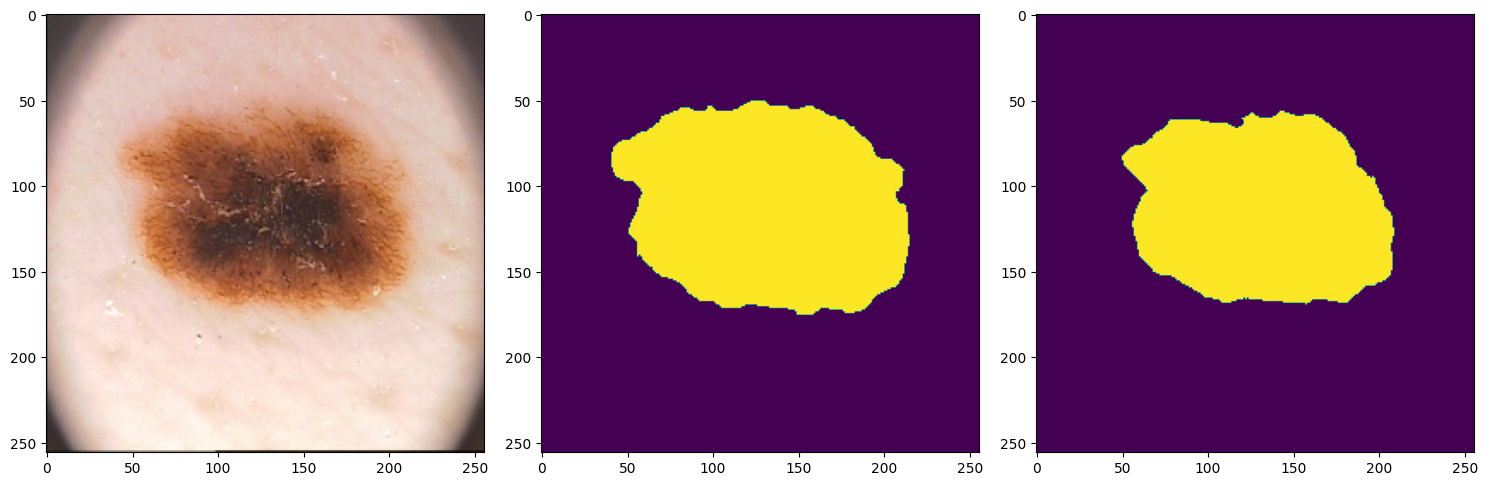

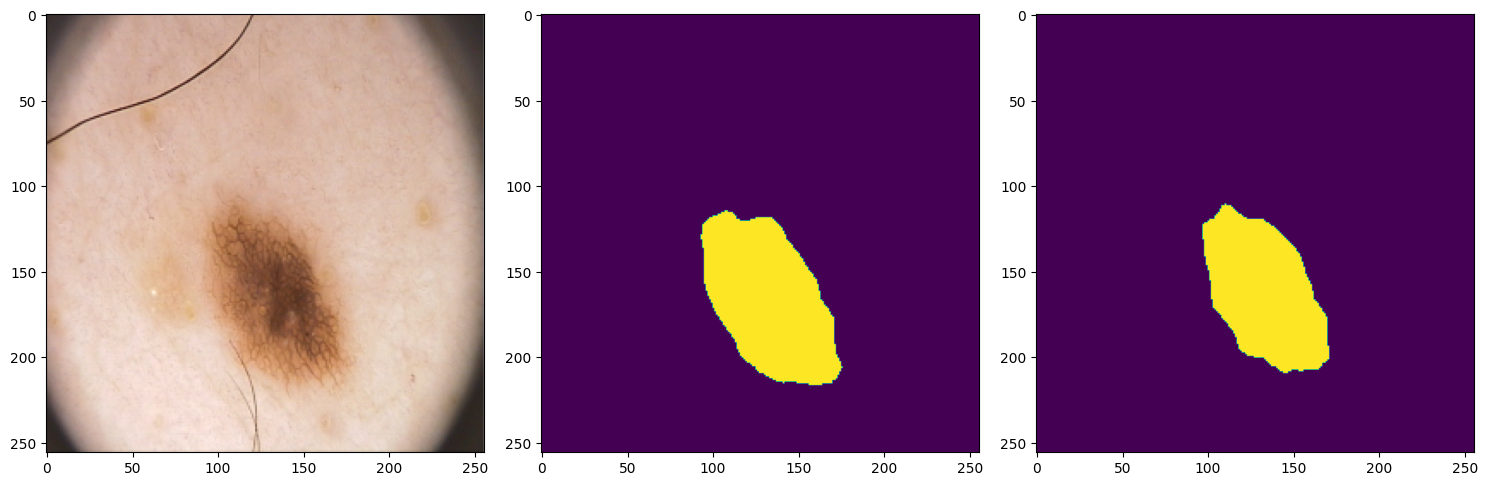

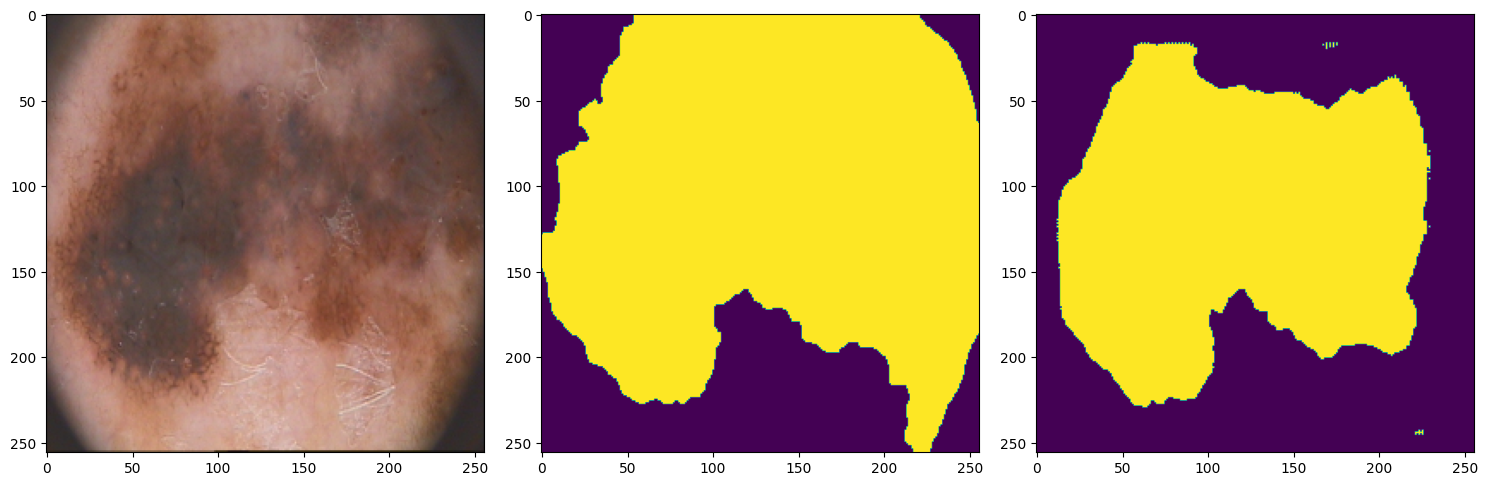

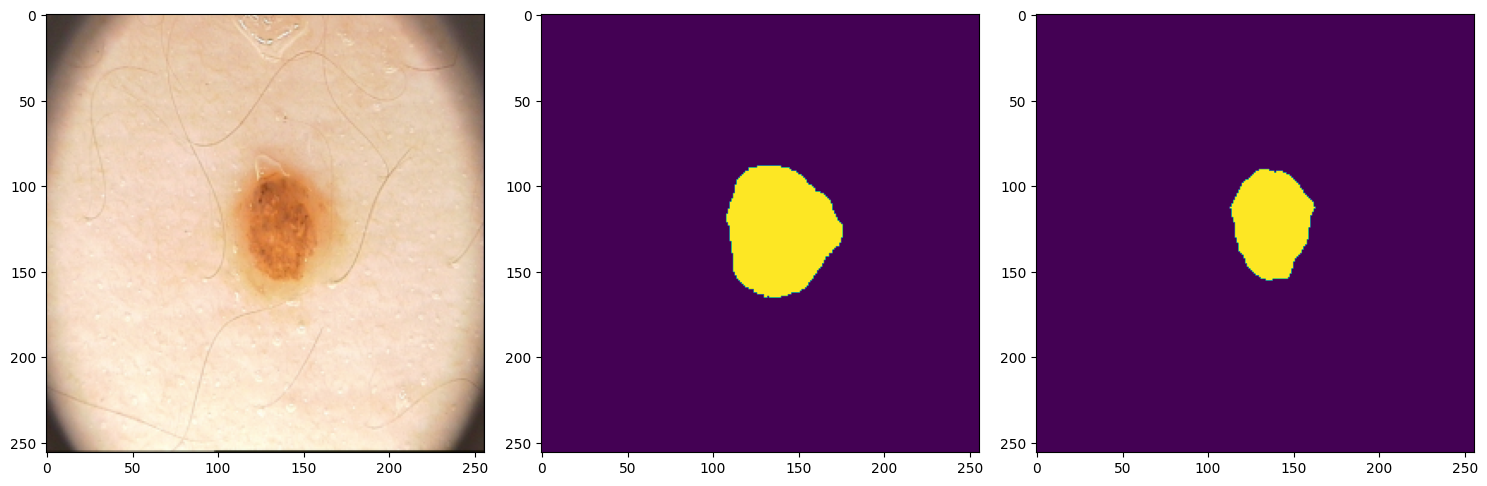

0.7003069519996643

In [ ]:
# Сделаем предсказание для Unet с Dice и посмотрим на результаты
test(model1, test_dataloader, device, plot = True)

Задание: обучите UNet на всех трех лоссах: BCE, Dice, Focal и сравните результаты с SegNet:
*   Какая модель дает лучшие значения по метрике?
*   Какая модель дает лучшие значения по лоссам?
*   Какая модель обучается быстрее?
*   Сравните визуально результаты SegNet и UNet.

Напишите развернутый ответ на вопросы.




1.   **SegNet на все трех лоссах дает лучшие значения по метрике и лоссам**

2.   **Обе модели обучаются примерно одинаковое количество времени**

3.   **Unet создает меншье шума на визуализации, что связано с использованием  skip connections, которые помогают восстановить структуру изображения, но Segnet точнее определяет область благобаря пулингу индексов**

